<a href="https://colab.research.google.com/github/iishipatel/100DaysofMLCode/blob/master/GANs_with_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iishipatel","key":"390d95299a265d58d9f94ca154c6b4bf"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
 ! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            782  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           2172  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            989  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           4156  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:13<00:00, 71.9MB/s]
100% 1.33G/1.33G [00:14<00:00, 102MB/s] 


In [ ]:
! ls

celeba-dataset.zip  kaggle.json  sample_data


In [ ]:
!unzip -q celeba-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

In [ ]:
path_celeb = []
train_path_celeb = "img_align_celeba/img_align_celeba"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [ ]:
new_path=path_celeb[0:25000]

In [ ]:
len(new_path)

25000

In [ ]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer
    
images = np.array(images) 

In [ ]:
train_data=images

In [ ]:
len(path_celeb)

202599

In [ ]:
print(train_data.shape)

(25000, 64, 64, 3)


<Figure size 720x720 with 0 Axes>

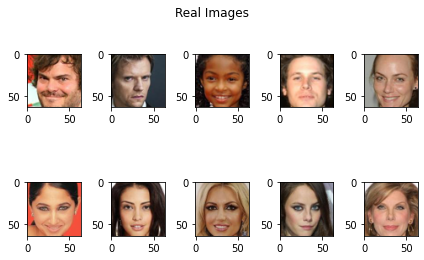

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=600
            
plt.tight_layout()
plt.show()

In [ ]:
X_train = train_data

In [ ]:
noise_shape = 100

In [ ]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 3]))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [ ]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.layers
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         3585219   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 55105     
Total params: 3,640,324
Trainable params: 3,584,323
Non-trainable params: 56,001
_________________________________________________________________


In [ ]:
epochs = 150  
batch_size = 128

In [ ]:
D_loss=[] 
G_loss=[]

Currently on Epoch 1
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


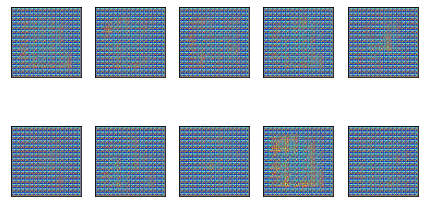

Epoch: 1,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epoch 2
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 2,  Loss: D_real = 0.789, D_fake = 0.053,  G = 0.143
Currently on Epoch 3
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 3,  Loss: D_real = 0.082, D_fake = 0.036,  G = 2.655
Currently on Epoch 4
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 4,  Loss: D_real = 0.044, D_fake = 0.012,  G = 0.062
Currently on Epoch 5
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 5,  Loss: D_real = 0.036, D_fake = 0.025,  G = 0.105
Currently on Epoch 6
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


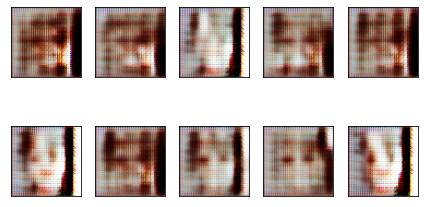

Epoch: 6,  Loss: D_real = 0.129, D_fake = 0.065,  G = 0.686
Currently on Epoch 7
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 7,  Loss: D_real = 0.184, D_fake = 0.182,  G = 0.254
Currently on Epoch 8
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 8,  Loss: D_real = 0.006, D_fake = 0.005,  G = 5.121
Currently on Epoch 9
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 9,  Loss: D_real = 0.428, D_fake = 0.535,  G = 2.730
Currently on Epoch 10
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 10,  Loss: D_real = 0.001, D_fake = 0.009,  G = 0.013
Currently on Epoch 11
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


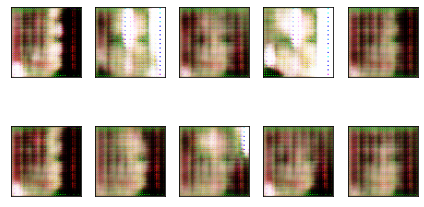

Epoch: 11,  Loss: D_real = 0.233, D_fake = 0.036,  G = 4.182
Currently on Epoch 12
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 12,  Loss: D_real = 0.227, D_fake = 0.341,  G = 0.862
Currently on Epoch 13
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 13,  Loss: D_real = 0.180, D_fake = 0.307,  G = 0.071
Currently on Epoch 14
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 14,  Loss: D_real = 0.755, D_fake = 0.210,  G = 1.723
Currently on Epoch 15
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 15,  Loss: D_real = 0.008, D_fake = 0.005,  G = 0.131
Currently on Epoch 16
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


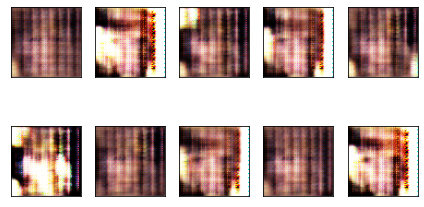

Epoch: 16,  Loss: D_real = 0.274, D_fake = 0.168,  G = 0.706
Currently on Epoch 17
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 17,  Loss: D_real = 1.315, D_fake = 0.401,  G = 1.577
Currently on Epoch 18
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 18,  Loss: D_real = 0.235, D_fake = 0.164,  G = 1.881
Currently on Epoch 19
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 19,  Loss: D_real = 0.319, D_fake = 0.228,  G = 3.244
Currently on Epoch 20
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 20,  Loss: D_real = 0.516, D_fake = 0.176,  G = 2.915
Currently on Epoch 21
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


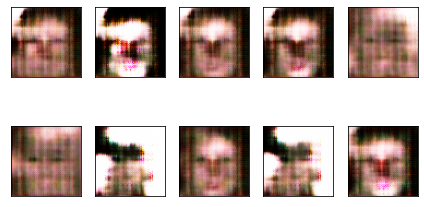

Epoch: 21,  Loss: D_real = 0.306, D_fake = 0.478,  G = 2.292
Currently on Epoch 22
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 22,  Loss: D_real = 0.359, D_fake = 0.269,  G = 4.159
Currently on Epoch 23
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 23,  Loss: D_real = 0.328, D_fake = 0.474,  G = 4.593
Currently on Epoch 24
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 24,  Loss: D_real = 0.268, D_fake = 0.132,  G = 2.067
Currently on Epoch 25
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 25,  Loss: D_real = 0.248, D_fake = 0.108,  G = 3.015
Currently on Epoch 26
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


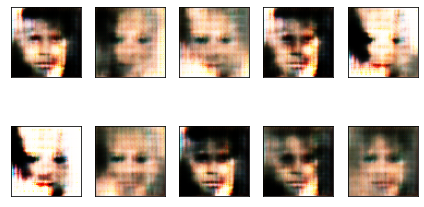

Epoch: 26,  Loss: D_real = 0.442, D_fake = 0.078,  G = 3.075
Currently on Epoch 27
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 27,  Loss: D_real = 0.491, D_fake = 0.182,  G = 3.258
Currently on Epoch 28
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 28,  Loss: D_real = 0.235, D_fake = 0.144,  G = 3.659
Currently on Epoch 29
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 29,  Loss: D_real = 0.240, D_fake = 0.338,  G = 3.560
Currently on Epoch 30
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 30,  Loss: D_real = 0.270, D_fake = 0.216,  G = 3.180
Currently on Epoch 31
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


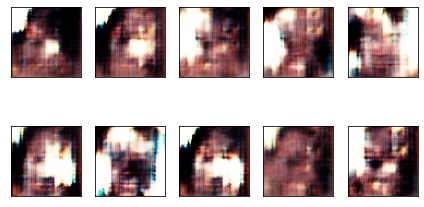

Epoch: 31,  Loss: D_real = 0.229, D_fake = 0.226,  G = 4.516
Currently on Epoch 32
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 32,  Loss: D_real = 0.394, D_fake = 0.303,  G = 2.387
Currently on Epoch 33
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 33,  Loss: D_real = 0.555, D_fake = 0.396,  G = 2.768
Currently on Epoch 34
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 34,  Loss: D_real = 0.448, D_fake = 0.281,  G = 2.115
Currently on Epoch 35
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 35,  Loss: D_real = 0.484, D_fake = 0.781,  G = 2.065
Currently on Epoch 36
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


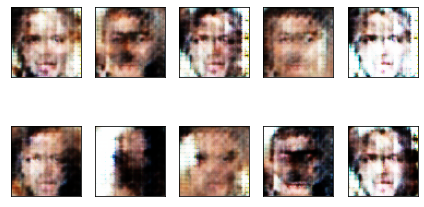

Epoch: 36,  Loss: D_real = 0.330, D_fake = 0.230,  G = 3.451
Currently on Epoch 37
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 37,  Loss: D_real = 0.335, D_fake = 0.369,  G = 2.345
Currently on Epoch 38
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 38,  Loss: D_real = 0.509, D_fake = 0.300,  G = 2.576
Currently on Epoch 39
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 39,  Loss: D_real = 0.451, D_fake = 0.390,  G = 2.519
Currently on Epoch 40
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 40,  Loss: D_real = 0.383, D_fake = 0.319,  G = 2.086
Currently on Epoch 41
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


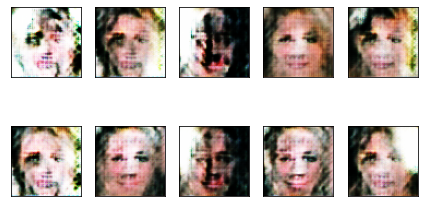

Epoch: 41,  Loss: D_real = 0.715, D_fake = 0.520,  G = 2.593
Currently on Epoch 42
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 42,  Loss: D_real = 0.314, D_fake = 0.203,  G = 2.582
Currently on Epoch 43
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 43,  Loss: D_real = 0.517, D_fake = 0.243,  G = 2.998
Currently on Epoch 44
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 44,  Loss: D_real = 0.797, D_fake = 1.451,  G = 2.514
Currently on Epoch 45
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 45,  Loss: D_real = 0.515, D_fake = 0.286,  G = 2.600
Currently on Epoch 46
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


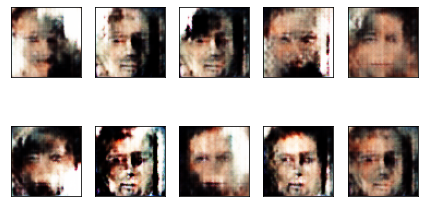

Epoch: 46,  Loss: D_real = 0.631, D_fake = 0.323,  G = 1.996
Currently on Epoch 47
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 47,  Loss: D_real = 0.248, D_fake = 0.361,  G = 3.776
Currently on Epoch 48
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 48,  Loss: D_real = 0.654, D_fake = 0.209,  G = 2.767
Currently on Epoch 49
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 49,  Loss: D_real = 0.529, D_fake = 0.435,  G = 2.331
Currently on Epoch 50
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 50,  Loss: D_real = 0.389, D_fake = 0.530,  G = 2.584
Currently on Epoch 51
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


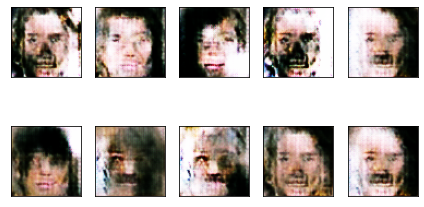

Epoch: 51,  Loss: D_real = 0.620, D_fake = 0.477,  G = 2.116
Currently on Epoch 52
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 52,  Loss: D_real = 0.385, D_fake = 0.450,  G = 2.519
Currently on Epoch 53
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 53,  Loss: D_real = 0.572, D_fake = 0.395,  G = 2.853
Currently on Epoch 54
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 54,  Loss: D_real = 0.416, D_fake = 0.426,  G = 3.553
Currently on Epoch 55
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 55,  Loss: D_real = 0.930, D_fake = 0.602,  G = 2.261
Currently on Epoch 56
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


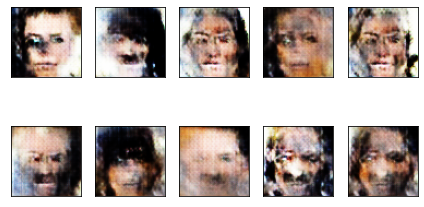

Epoch: 56,  Loss: D_real = 0.340, D_fake = 0.470,  G = 2.804
Currently on Epoch 57
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 57,  Loss: D_real = 0.588, D_fake = 0.430,  G = 2.418
Currently on Epoch 58
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 58,  Loss: D_real = 0.597, D_fake = 0.495,  G = 2.292
Currently on Epoch 59
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 59,  Loss: D_real = 0.826, D_fake = 0.353,  G = 1.952
Currently on Epoch 60
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 60,  Loss: D_real = 0.501, D_fake = 0.549,  G = 2.177
Currently on Epoch 61
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


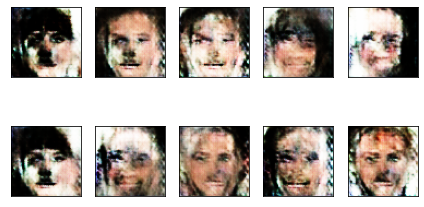

Epoch: 61,  Loss: D_real = 0.459, D_fake = 0.607,  G = 2.138
Currently on Epoch 62
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 62,  Loss: D_real = 0.406, D_fake = 0.481,  G = 2.588
Currently on Epoch 63
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 63,  Loss: D_real = 0.897, D_fake = 0.407,  G = 2.495
Currently on Epoch 64
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 64,  Loss: D_real = 0.371, D_fake = 0.625,  G = 2.445
Currently on Epoch 65
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 65,  Loss: D_real = 0.422, D_fake = 0.350,  G = 2.331
Currently on Epoch 66
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


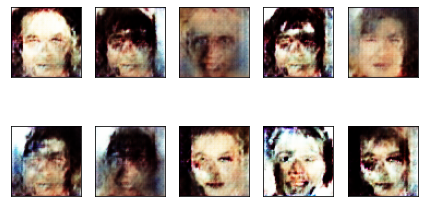

Epoch: 66,  Loss: D_real = 0.488, D_fake = 0.308,  G = 2.495
Currently on Epoch 67
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 67,  Loss: D_real = 0.685, D_fake = 0.376,  G = 1.971
Currently on Epoch 68
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 68,  Loss: D_real = 0.571, D_fake = 0.270,  G = 2.911
Currently on Epoch 69
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 69,  Loss: D_real = 0.383, D_fake = 0.421,  G = 2.338
Currently on Epoch 70
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 70,  Loss: D_real = 0.205, D_fake = 0.359,  G = 2.840
Currently on Epoch 71
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


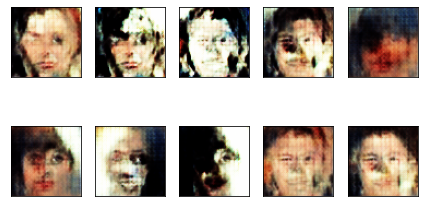

Epoch: 71,  Loss: D_real = 0.505, D_fake = 0.273,  G = 2.137
Currently on Epoch 72
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 72,  Loss: D_real = 0.230, D_fake = 0.163,  G = 3.474
Currently on Epoch 73
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 73,  Loss: D_real = 0.274, D_fake = 0.394,  G = 2.499
Currently on Epoch 74
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 74,  Loss: D_real = 0.281, D_fake = 0.324,  G = 3.357
Currently on Epoch 75
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 75,  Loss: D_real = 0.640, D_fake = 0.357,  G = 2.425
Currently on Epoch 76
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


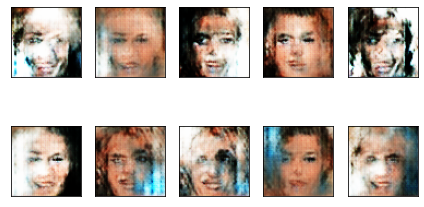

Epoch: 76,  Loss: D_real = 0.455, D_fake = 0.559,  G = 1.838
Currently on Epoch 77
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 77,  Loss: D_real = 0.580, D_fake = 0.325,  G = 2.205
Currently on Epoch 78
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 78,  Loss: D_real = 0.466, D_fake = 0.313,  G = 2.428
Currently on Epoch 79
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 79,  Loss: D_real = 0.723, D_fake = 0.461,  G = 2.115
Currently on Epoch 80
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 80,  Loss: D_real = 0.517, D_fake = 0.310,  G = 2.550
Currently on Epoch 81
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


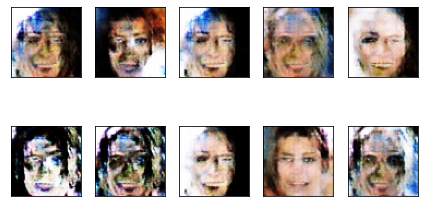

Epoch: 81,  Loss: D_real = 0.295, D_fake = 0.277,  G = 2.803
Currently on Epoch 82
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 82,  Loss: D_real = 0.519, D_fake = 0.393,  G = 2.800
Currently on Epoch 83
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 83,  Loss: D_real = 0.642, D_fake = 0.473,  G = 2.220
Currently on Epoch 84
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 84,  Loss: D_real = 0.473, D_fake = 0.755,  G = 2.940
Currently on Epoch 85
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 85,  Loss: D_real = 0.395, D_fake = 0.410,  G = 2.283
Currently on Epoch 86
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


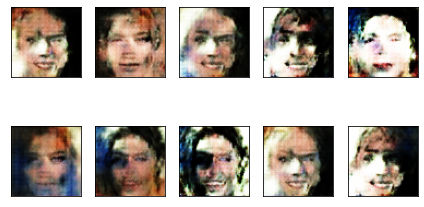

Epoch: 86,  Loss: D_real = 0.432, D_fake = 0.339,  G = 2.745
Currently on Epoch 87
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 87,  Loss: D_real = 0.370, D_fake = 0.270,  G = 2.354
Currently on Epoch 88
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 88,  Loss: D_real = 0.479, D_fake = 0.280,  G = 3.138
Currently on Epoch 89
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 89,  Loss: D_real = 0.565, D_fake = 0.488,  G = 2.328
Currently on Epoch 90
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 90,  Loss: D_real = 0.392, D_fake = 0.536,  G = 2.712
Currently on Epoch 91
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


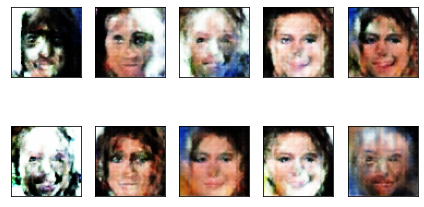

Epoch: 91,  Loss: D_real = 0.454, D_fake = 0.225,  G = 2.417
Currently on Epoch 92
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 92,  Loss: D_real = 0.380, D_fake = 0.438,  G = 2.060
Currently on Epoch 93
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 93,  Loss: D_real = 0.761, D_fake = 0.180,  G = 2.334
Currently on Epoch 94
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 94,  Loss: D_real = 0.360, D_fake = 0.193,  G = 2.707
Currently on Epoch 95
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 95,  Loss: D_real = 0.535, D_fake = 0.416,  G = 2.369
Currently on Epoch 96
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


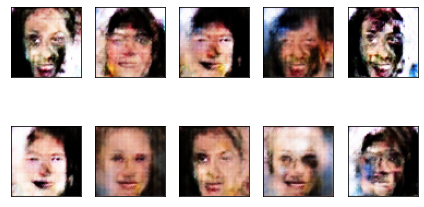

Epoch: 96,  Loss: D_real = 0.443, D_fake = 0.353,  G = 2.715
Currently on Epoch 97
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 97,  Loss: D_real = 0.497, D_fake = 0.348,  G = 2.386
Currently on Epoch 98
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 98,  Loss: D_real = 0.259, D_fake = 0.153,  G = 4.531
Currently on Epoch 99
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 99,  Loss: D_real = 0.639, D_fake = 0.348,  G = 2.626
Currently on Epoch 100
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 100,  Loss: D_real = 0.402, D_fake = 0.242,  G = 2.934
Currently on Epoch 101
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


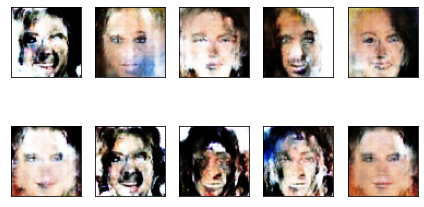

Epoch: 101,  Loss: D_real = 0.418, D_fake = 0.418,  G = 2.460
Currently on Epoch 102
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 102,  Loss: D_real = 0.445, D_fake = 0.438,  G = 2.041
Currently on Epoch 103
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 103,  Loss: D_real = 0.362, D_fake = 0.283,  G = 3.119
Currently on Epoch 104
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 104,  Loss: D_real = 0.452, D_fake = 0.541,  G = 2.524
Currently on Epoch 105
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 105,  Loss: D_real = 0.403, D_fake = 0.536,  G = 2.839
Currently on Epoch 106
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


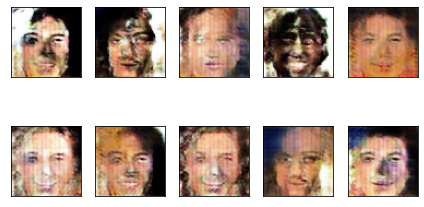

Epoch: 106,  Loss: D_real = 0.150, D_fake = 1.493,  G = 3.576
Currently on Epoch 107
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 107,  Loss: D_real = 0.841, D_fake = 0.658,  G = 1.726
Currently on Epoch 108
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 108,  Loss: D_real = 0.343, D_fake = 0.725,  G = 2.554
Currently on Epoch 109
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 109,  Loss: D_real = 0.325, D_fake = 1.990,  G = 7.297
Currently on Epoch 110
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 110,  Loss: D_real = 0.434, D_fake = 0.472,  G = 2.267
Currently on Epoch 111
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


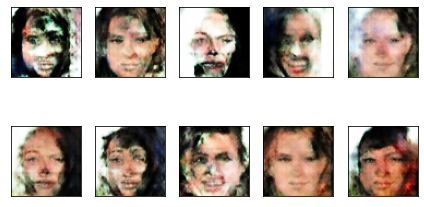

Epoch: 111,  Loss: D_real = 0.545, D_fake = 0.189,  G = 2.668
Currently on Epoch 112
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 112,  Loss: D_real = 0.318, D_fake = 0.385,  G = 2.248
Currently on Epoch 113
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 113,  Loss: D_real = 0.930, D_fake = 0.308,  G = 1.931
Currently on Epoch 114
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 114,  Loss: D_real = 0.414, D_fake = 0.710,  G = 2.724
Currently on Epoch 115
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 115,  Loss: D_real = 0.314, D_fake = 0.687,  G = 2.229
Currently on Epoch 116
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


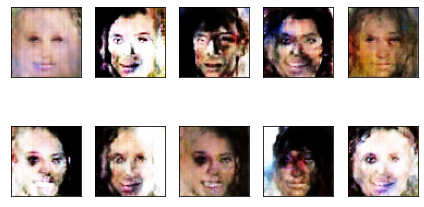

Epoch: 116,  Loss: D_real = 0.555, D_fake = 0.268,  G = 2.931
Currently on Epoch 117
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 117,  Loss: D_real = 0.227, D_fake = 0.431,  G = 3.236
Currently on Epoch 118
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 118,  Loss: D_real = 0.350, D_fake = 0.479,  G = 3.419
Currently on Epoch 119
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 119,  Loss: D_real = 0.576, D_fake = 0.727,  G = 3.416
Currently on Epoch 120
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 120,  Loss: D_real = 0.205, D_fake = 0.404,  G = 2.735
Currently on Epoch 121
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


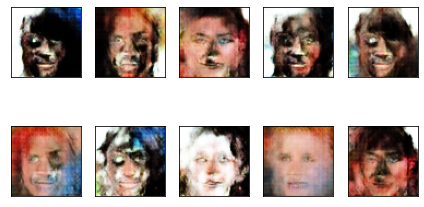

Epoch: 121,  Loss: D_real = 0.343, D_fake = 1.072,  G = 1.936
Currently on Epoch 122
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 122,  Loss: D_real = 0.559, D_fake = 0.476,  G = 2.331
Currently on Epoch 123
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 123,  Loss: D_real = 0.315, D_fake = 0.371,  G = 3.165
Currently on Epoch 124
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 124,  Loss: D_real = 0.348, D_fake = 0.347,  G = 2.536
Currently on Epoch 125
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 125,  Loss: D_real = 0.304, D_fake = 0.523,  G = 2.553
Currently on Epoch 126
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


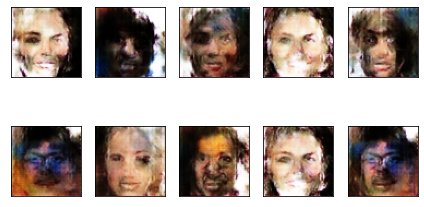

Epoch: 126,  Loss: D_real = 0.306, D_fake = 0.282,  G = 3.451
Currently on Epoch 127
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 127,  Loss: D_real = 0.533, D_fake = 0.274,  G = 2.769
Currently on Epoch 128
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 128,  Loss: D_real = 0.287, D_fake = 0.749,  G = 2.661
Currently on Epoch 129
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 129,  Loss: D_real = 0.557, D_fake = 0.300,  G = 1.976
Currently on Epoch 130
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 130,  Loss: D_real = 0.324, D_fake = 0.468,  G = 2.328
Currently on Epoch 131
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


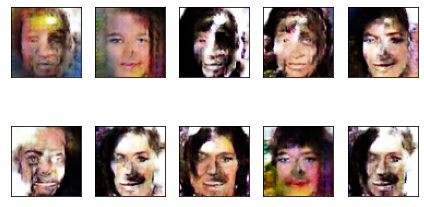

Epoch: 131,  Loss: D_real = 0.490, D_fake = 0.725,  G = 2.520
Currently on Epoch 132
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 132,  Loss: D_real = 0.687, D_fake = 0.243,  G = 2.346
Currently on Epoch 133
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 133,  Loss: D_real = 0.289, D_fake = 0.186,  G = 3.356
Currently on Epoch 134
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 134,  Loss: D_real = 0.527, D_fake = 0.508,  G = 2.486
Currently on Epoch 135
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 135,  Loss: D_real = 0.381, D_fake = 0.562,  G = 2.654
Currently on Epoch 136
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


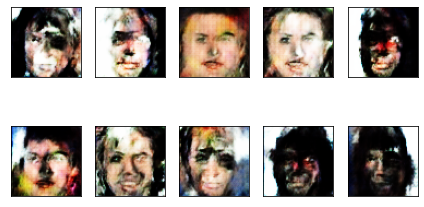

Epoch: 136,  Loss: D_real = 0.419, D_fake = 0.504,  G = 2.273
Currently on Epoch 137
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 137,  Loss: D_real = 0.584, D_fake = 0.274,  G = 2.285
Currently on Epoch 138
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 138,  Loss: D_real = 0.330, D_fake = 0.232,  G = 3.465
Currently on Epoch 139
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 139,  Loss: D_real = 0.356, D_fake = 0.225,  G = 2.775
Currently on Epoch 140
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 140,  Loss: D_real = 0.602, D_fake = 0.531,  G = 2.964
Currently on Epoch 141
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


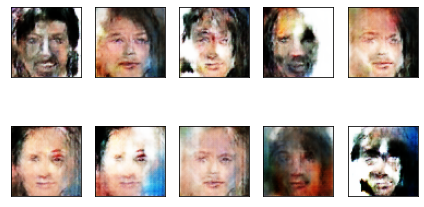

Epoch: 141,  Loss: D_real = 0.349, D_fake = 0.712,  G = 2.118
Currently on Epoch 142
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 142,  Loss: D_real = 0.505, D_fake = 0.290,  G = 2.808
Currently on Epoch 143
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 143,  Loss: D_real = 0.500, D_fake = 0.214,  G = 2.610
Currently on Epoch 144
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 144,  Loss: D_real = 0.443, D_fake = 0.346,  G = 2.990
Currently on Epoch 145
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 145,  Loss: D_real = 0.490, D_fake = 0.466,  G = 2.673
Currently on Epoch 146
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195


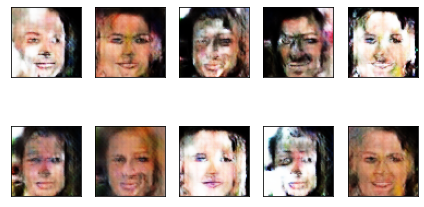

Epoch: 146,  Loss: D_real = 0.277, D_fake = 0.225,  G = 3.417
Currently on Epoch 147
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 147,  Loss: D_real = 0.635, D_fake = 0.314,  G = 2.342
Currently on Epoch 148
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 148,  Loss: D_real = 0.555, D_fake = 0.548,  G = 2.711
Currently on Epoch 149
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 149,  Loss: D_real = 0.487, D_fake = 0.633,  G = 3.043
Currently on Epoch 150
	Currently on batch number 0 of 195
	Currently on batch number 100 of 195
Epoch: 150,  Loss: D_real = 0.506, D_fake = 0.363,  G = 2.652
Training is complete


In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

In [ ]:
noise=np.random.uniform(-1,1,size=[500,noise_shape])

In [ ]:
im=generator.predict(noise)


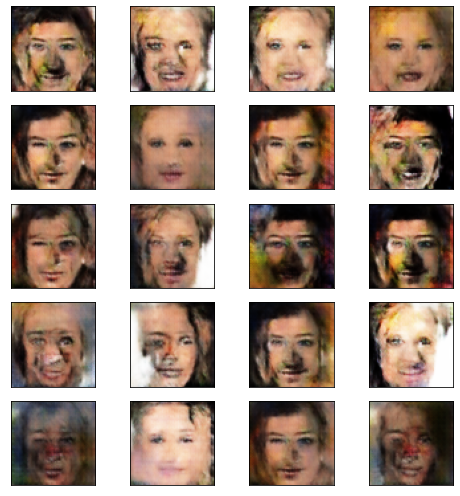

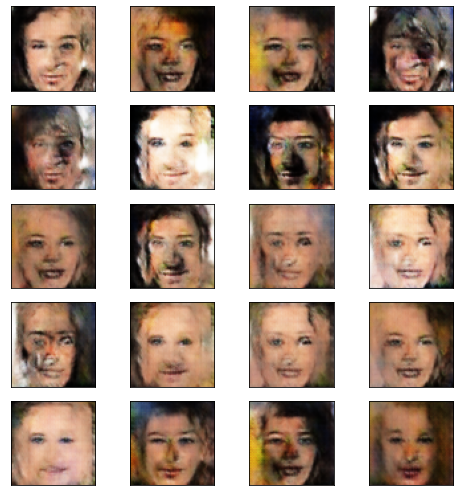

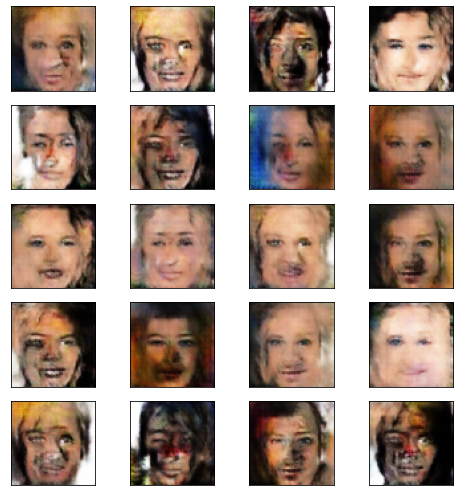

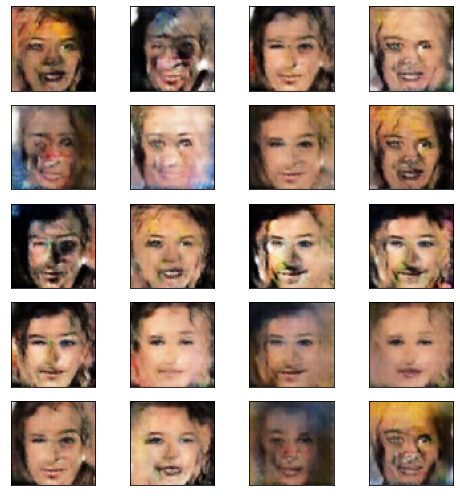

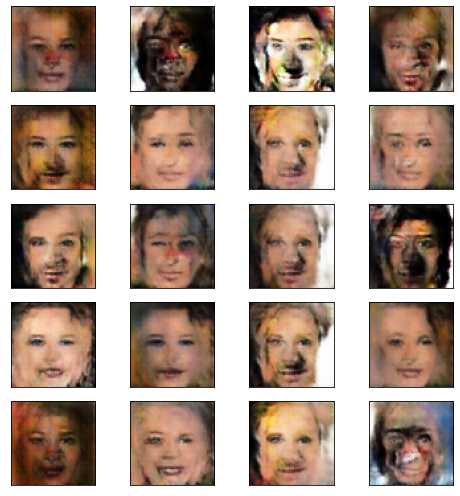

In [ ]:
for i in range(5):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

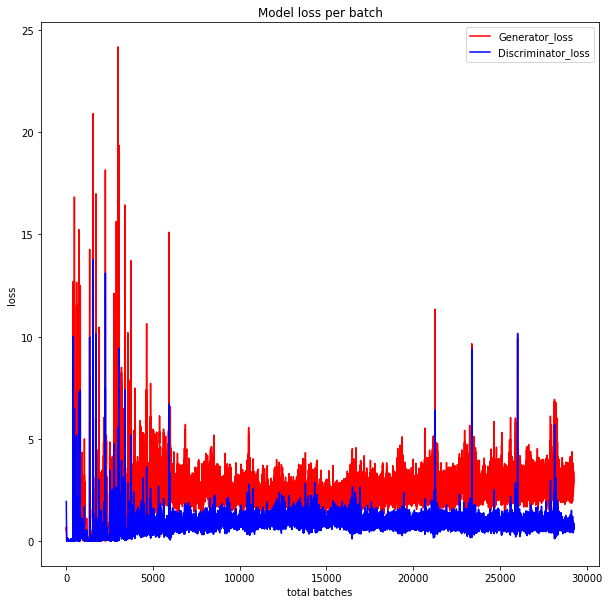

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

In [ ]:
!mkdir -p saved_model
GAN.save('saved_model/DCGAN') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/DCGAN/assets


In [ ]:
def generate_and_save_images():
  noise=np.random.uniform(-1,1,size=[100,noise_shape])
  im=generator.predict(noise)

  

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()